In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "../data"

In [3]:
df = pd.read_csv(os.path.join(data_dir, "OD_201912_weekday.csv"), index_col=0)

In [4]:
df.head()

,origin,destination,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
ind,,,,,,,,,,,,,,,,,,,,,
0,ANAK BUKIT,NORTH COAST,475.0,1159.0,2451.0,2489.0,2280.0,2280.0,2242.0,1501.0,...,874.0,2793.0,3496.0,4199.0,3230.0,3743.0,5396.0,6023.0,4370.0,2584.0
1,CLEMENTI CENTRAL,MARITIME SQUARE,4959.0,10450.0,15162.0,13167.0,10488.0,11590.0,10450.0,10678.0,...,8892.0,8018.0,8949.0,10678.0,12122.0,6821.0,4959.0,2280.0,1653.0,817.0
2,PAYA LEBAR NORTH,PASIR RIS WEST,228.0,1197.0,1558.0,1843.0,3287.0,2565.0,5225.0,6137.0,...,3762.0,4180.0,5282.0,8455.0,11324.0,9348.0,7771.0,9044.0,5985.0,2622.0
3,TRAFALGAR,TOA PAYOH WEST,1900.0,2299.0,1881.0,931.0,874.0,532.0,646.0,646.0,...,418.0,437.0,570.0,361.0,304.0,532.0,418.0,304.0,190.0,19.0
4,BALESTIER,BALESTIER,17119.0,76646.0,126616.0,205219.0,167770.0,160056.0,171380.0,188746.0,...,141208.0,139840.0,149264.0,187492.0,224162.0,194617.0,134064.0,126901.0,102999.0,63460.0


In [5]:
len(df)

31326

In [6]:
df2 = df.dropna(subset=["origin", "destination"])
len(df2)

31267

In [7]:
df = df2

In [8]:
nodes = list(set(df["origin"].tolist()) | set(df["destination"].tolist()))
len(nodes)

303

In [9]:
dg = nx.DiGraph()
dg.add_nodes_from(nodes)
for i in tqdm(range(len(df))):
    row = df.iloc[i]
    o = row["origin"]
    d = row["destination"]
    weights = { "hour_{}".format(str(hr).zfill(2)): row["hour_{}".format(str(hr).zfill(2))] for hr in range(5,24) }
    dg.add_edge(o, d, **weights)
dg.number_of_nodes(), dg.number_of_edges()

100%|██████████| 31267/31267 [00:10<00:00, 3019.63it/s]


(303, 31267)

In [10]:
for u,v,d in dg.edges(data=True):
    print(d)
    break

{'hour_05': 342.0, 'hour_06': 191.0, 'hour_07': 195.0, 'hour_08': 234.0, 'hour_09': 306.0, 'hour_10': 322.0, 'hour_11': 228.0, 'hour_12': 191.0, 'hour_13': 283.0, 'hour_14': 359.0, 'hour_15': 408.0, 'hour_16': 361.0, 'hour_17': 524.0, 'hour_18': 498.0, 'hour_19': 523.0, 'hour_20': 535.0, 'hour_21': 625.0, 'hour_22': 431.0, 'hour_23': 144.0}


In [11]:
times = [ "hour_{}".format(str(hr).zfill(2)) for hr in range(5,24) ]

In [12]:
times[0]

'hour_05'

In [13]:
nx.to_numpy_matrix(dg, weight="hour_05")

matrix([[4.332e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 1.000e+00, 4.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.501e+03, 0.000e+00,
         0.000e+00],
        [0.000e+00, 4.000e+00, 4.800e+01, ..., 0.000e+00, 2.280e+02,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 8.132e+03,
         1.824e+03]])

In [14]:
matrices = []
total_riderships = []
Ncount = dg.number_of_nodes()

for time in tqdm(times):
    #print(time)
    mat = nx.to_numpy_matrix(dg, weight=time)
    #matrices.append( mat )
    total_riderships.append( mat.sum() )
    ODt = mat.transpose()
    osum = ODt.sum(axis=0)
    CNt = np.zeros((Ncount,Ncount))
    for i in range(ODt.shape[0]):
        for j in range(ODt.shape[1]):
            s = float(osum[0,j])
            if s>0:
                v = float(ODt[i,j])
                CNt[i,j] = v/s
    matrices.append(CNt)


100%|██████████| 19/19 [00:04<00:00,  4.73it/s]


In [15]:
all_flows = sum(total_riderships)
total_riderships = [ r/all_flows for r in total_riderships ]

In [16]:
#total_riderships

In [40]:
number_of_loops = 31
mat = matrices[4]
Ncount

epidemic_risk = np.matrix(np.zeros((1, Ncount))).transpose() ## init EpiRank values
epidemic_risk[4,0] = 1.
#epidemic_risk

mat_store = [epidemic_risk]
for i in range(number_of_loops):
    #print(i)
    old_epidemic_risk = epidemic_risk.copy()
    epidemic_risk = mat*epidemic_risk# + old_epidemic_risk
    #epidemic_risk = np.matrix(np.where(epidemic_risk>1., 1., epidemic_risk))
    #print(epidemic_risk)
    mat_store.append(epidemic_risk)
print('epirank calculation done after iteration: '+str(i+1))

epirank calculation done after iteration: 31


In [29]:
len(mat_store)

32

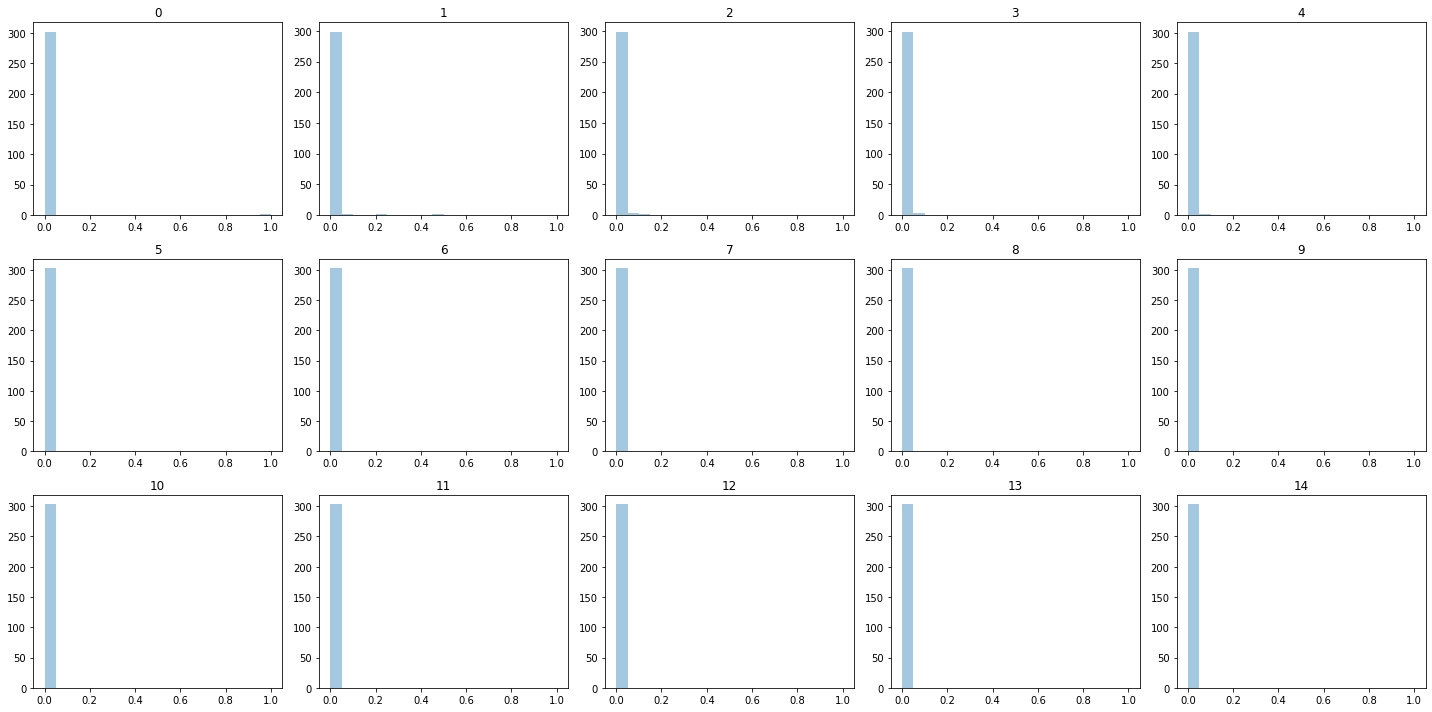

In [30]:
fig, axg = plt.subplots(3,5, figsize=(20,10))
axs = axg.flatten()

for i in range(len(axs)):
    ax = axs[i]
    this_mat = mat_store[i]
    sns.distplot(np.array(this_mat), ax=ax, bins=[i*0.05 for i in range(21)], kde=False)
    ax.set_title(i)
plt.tight_layout()

In [41]:
#vals = [ i[0] for i in epidemic_risk.tolist() ]
vals = {}
for i in range(len(mat_store)):
    istr = "iter_{}".format(str(i).zfill(2))
    this_mat = mat_store[i]
    this_val = [ i[0] for i in this_mat.tolist() ]
    vals[istr] = this_val
nodes = list(dg.nodes())
epi_value = {}
for i in range(len(epidemic_risk)):
    epi_value[nodes[i]] = { k:v[i] for k,v in vals.items() }

In [42]:
df_res = pd.DataFrame.from_dict(epi_value, orient="index")
df_res.head(10)

,iter_00,iter_01,iter_02,iter_03,iter_04,iter_05,iter_06,iter_07,iter_08,iter_09,...,iter_22,iter_23,iter_24,iter_25,iter_26,iter_27,iter_28,iter_29,iter_30,iter_31
ADMIRALTY,0.0,0.0,0.000000,0.000023,0.000056,0.000098,0.000141,0.000182,0.000221,0.000259,...,0.000538,0.000548,0.000556,0.000564,0.000571,0.000577,0.000582,0.000587,0.000591,0.000595
AIRPORT ROAD,0.0,0.0,0.000000,0.000028,0.000055,0.000072,0.000084,0.000093,0.000099,0.000105,...,0.000130,0.000131,0.000131,0.000132,0.000132,0.000132,0.000133,0.000133,0.000133,0.000134
ALEXANDRA HILL,0.0,0.0,0.006180,0.011430,0.014174,0.015317,0.015727,0.015518,0.015053,0.014518,...,0.011351,0.011283,0.011223,0.011171,0.011126,0.011086,0.011052,0.011022,0.010995,0.010972
ALEXANDRA NORTH,0.0,0.0,0.000000,0.000369,0.000585,0.000730,0.000798,0.000819,0.000816,0.000803,...,0.000661,0.000657,0.000654,0.000651,0.000649,0.000647,0.000645,0.000643,0.000641,0.000640
ALJUNIED,0.0,0.0,0.012790,0.016003,0.016379,0.016542,0.016448,0.016354,0.016256,0.016164,...,0.015691,0.015689,0.015688,0.015689,0.015690,0.015693,0.015695,0.015699,0.015702,0.015706
ANAK BUKIT,0.0,0.0,0.000285,0.002285,0.003433,0.004639,0.005745,0.006621,0.007252,0.007677,...,0.008033,0.008001,0.007970,0.007941,0.007914,0.007889,0.007866,0.007845,0.007825,0.007808
ANCHORVALE,0.0,0.0,0.000070,0.000087,0.000188,0.000262,0.000330,0.000393,0.000450,0.000503,...,0.000839,0.000848,0.000856,0.000864,0.000870,0.000876,0.000881,0.000886,0.000890,0.000894
ANG MO KIO TOWN CENTRE,0.0,0.0,0.001456,0.001124,0.001567,0.001954,0.002345,0.002694,0.002998,0.003258,...,0.004520,0.004547,0.004572,0.004593,0.004612,0.004629,0.004643,0.004656,0.004668,0.004678
ANSON,0.0,0.0,0.001901,0.003834,0.004766,0.004893,0.004709,0.004480,0.004269,0.004086,...,0.003223,0.003206,0.003192,0.003180,0.003169,0.003160,0.003152,0.003145,0.003139,0.003134
BALESTIER,0.0,0.0,0.002107,0.003678,0.005018,0.005924,0.006489,0.006843,0.007061,0.007191,...,0.007224,0.007219,0.007214,0.007210,0.007207,0.007204,0.007202,0.007201,0.007200,0.007199


In [43]:
xs = []
ys = []
ns = []
for k,v in epi_value.items():
    x,y = pos[k]
    ns.append(k)
    xs.append(x)
    ys.append(y)
    

In [44]:
def plot_iter(iter_str):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_aspect("equal")

    ss = []
    for k,v in epi_value.items():
        ss.append(v[iter_str])
    print(iter_str, sum(ss))

    ax.scatter(xs, ys, s=[s*2000 for s in ss])
    parea.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)
    ax.set_xlim([4000,50000])
    ax.set_ylim([25000,50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(iter_str)
    
    plt.tight_layout()
    plt.savefig("iter_sim_simple/{}-b.png".format(iter_str), bbox_inches="tight", dpi=100)
    plt.close()

In [45]:
for i in range(len(mat_store)):
    iter_str = "iter_{}".format(str(i).zfill(2))
    plot_iter(iter_str)

iter_00 1.0
iter_01 1.0
iter_02 0.9999999999999993
iter_03 0.9999999999999996
iter_04 1.0
iter_05 1.000000000000001
iter_06 1.0000000000000007
iter_07 0.9999999999999996
iter_08 0.9999999999999999
iter_09 1.0000000000000002
iter_10 0.9999999999999999
iter_11 0.9999999999999999
iter_12 1.0000000000000009
iter_13 1.000000000000001
iter_14 1.0000000000000004
iter_15 1.0000000000000002
iter_16 0.9999999999999996
iter_17 0.9999999999999997
iter_18 0.9999999999999997
iter_19 1.0000000000000002
iter_20 0.9999999999999994
iter_21 0.9999999999999994
iter_22 1.0
iter_23 1.0
iter_24 0.9999999999999998
iter_25 1.0000000000000007
iter_26 1.0000000000000002
iter_27 0.9999999999999997
iter_28 1.0000000000000002
iter_29 0.9999999999999997
iter_30 0.9999999999999999
iter_31 1.0000000000000004


In [49]:
exfac = np.matrix(np.ones((1, Ncount))/float(Ncount)).transpose()

In [50]:
number_of_loops = 10000
dfac = 0.95

In [51]:
epidemic_risk = np.matrix(np.ones((1, Ncount))/float(Ncount)).transpose() ## init EpiRank values

print('preparation done, start iterating')
### start running ###
for i in range(number_of_loops):
    old_epidemic_risk = epidemic_risk.copy()
    mat_part = sum([ r*CNt*epidemic_risk for r,CNt in zip(total_riderships, matrices)])
    epidemic_risk = (1. - dfac) * exfac + dfac * mat_part
    if np.ma.allequal(epidemic_risk, old_epidemic_risk): break
#print('iteration count:', i)
print('epirank calculation done after iteration: '+str(i))

preparation done, start iterating
epirank calculation done after iteration: 596


In [52]:
vals = [ i[0] for i in epidemic_risk.tolist() ]
nodes = list(dg.nodes())
epi_value = {}
for i in range(len(epidemic_risk)):
    epi_value[nodes[i]] = vals[i]

In [53]:
epi_value["TOA PAYOH CENTRAL"]

0.01271079706500854

In [23]:
import json
with open(os.path.join("../data", 'subzone_centroid_pos.json'), 'r') as fread:
    pos = json.load(fread)
pos["MARINA SOUTH"]

[31595.83574613999, 29220.18737674884]

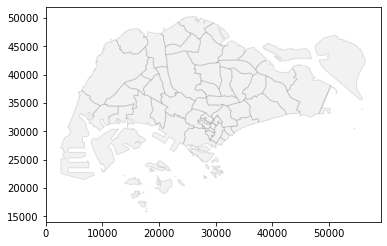

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
os.listdir("../data")
parea = gpd.read_file("../data/planning-area-2014/MP14_PLNG_AREA_WEB_PL.shp")
parea.plot(color="grey", edgecolor="k", alpha=0.1)

In [56]:
xs = []
ys = []
ss = []
ns = []

for k,v in epi_value.items():
    x,y = pos[k]
    ns.append(k)
    xs.append(x)
    ys.append(y)
    ss.append(v)
sum(ss)

0.9952777604532611

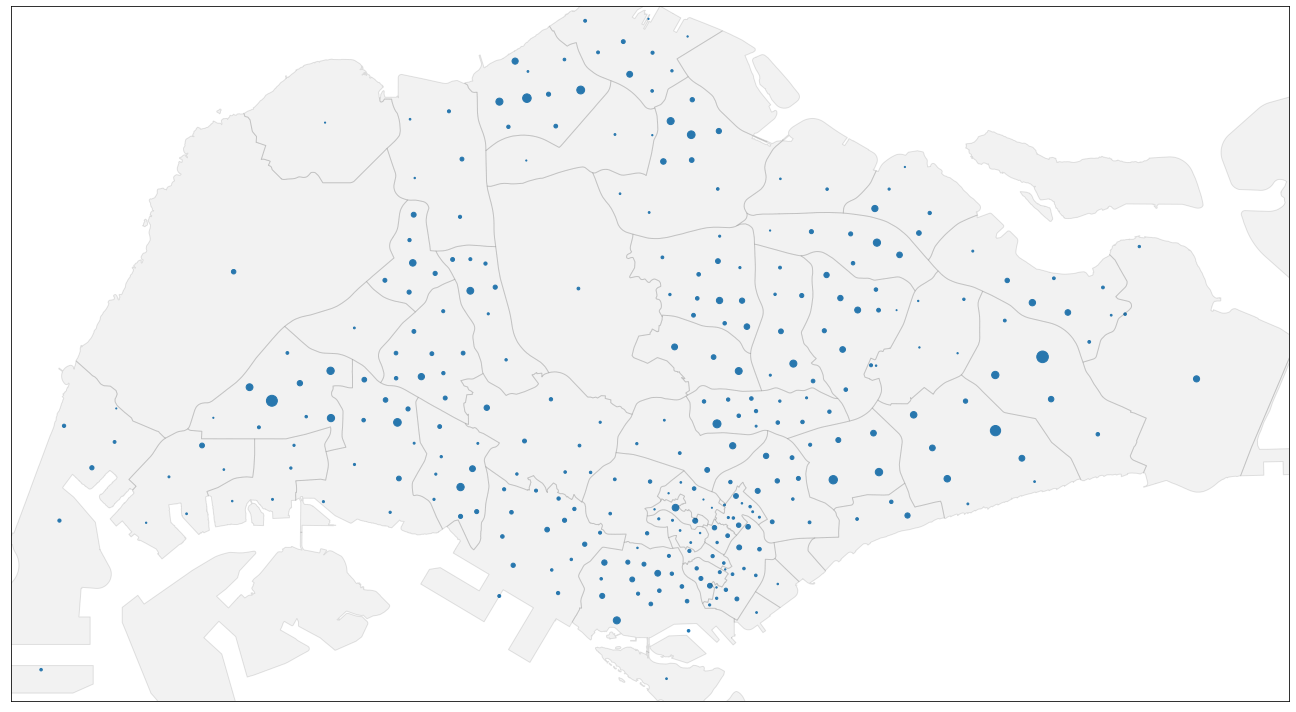

In [58]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect("equal")
ax.scatter(xs, ys, s=[s*5000 for s in ss])
parea.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)
ax.set_xlim([4000,50000])
ax.set_ylim([25000,50000])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()

In [59]:
df_res = pd.DataFrame.from_dict({"name": ns, "epi_val": ss, "loc_x": xs, "loc_y": ys})
df_res.head()

,name,epi_val,loc_x,loc_y
0,SERANGOON NORTH,0.003393,32458.803173,39597.640171
1,FAJAR,0.002066,21080.957329,40748.092643
2,BEDOK NORTH,0.021140,39429.210492,34737.619447
3,KAKI BUKIT,0.008467,36485.395174,35307.040807
4,DHOBY GHAUT,0.003904,29320.073555,31245.748357


In [60]:
from shapely.geometry import Point

In [61]:
parea.crs

{'proj': 'tmerc',
 'lat_0': 1.366666666666667,
 'lon_0': 103.8333333333333,
 'k': 1,
 'x_0': 28001.642,
 'y_0': 38744.572,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

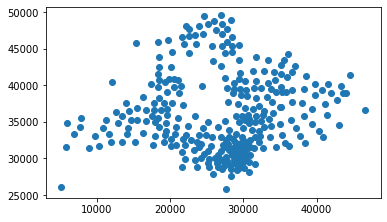

In [62]:
pts = []
for x,y in zip(xs, ys):
    pts.append(Point(x,y))
gdf = gpd.GeoDataFrame(df_res, geometry=pts, crs=parea.crs)
gdf.plot()

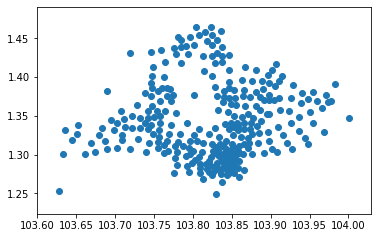

In [63]:
gdf2 = gdf.to_crs("epsg:4326")
gdf2.plot()

In [64]:
lon = []
lat = []
for pt in gdf2.geometry:
    #print(pt.x, pt.y)
    lon.append(pt.x)
    lat.append(pt.y)
    #break

In [65]:
df_res["lon"] = lon
df_res["lat"] = lat

In [66]:
df_res.to_csv("epirank_result.csv", index_label="ind")